<h1>Importing all required libraries<h1>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

import string
string.punctuation

import numpy as np
import re 

#importing nlp library
#pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
#Stop words present in the library
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['photo'])
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

from sklearn import preprocessing 
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#pip install catboost
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

import warnings
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/neerajnagendra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/neerajnagendra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
train = pd.read_csv("training_data.csv")

<h3>Exploring the training data<h3>

In [4]:
train.head()

,natid,title,pub_date,uri,category,text
0,blogandpostid/blog/post/3949-40365,You're Already On A Cloud -- What Could Poss...,2020-05-07,http://www.forbes.com/sites/forbestechcouncil/...,Technology and Computing,Photo: Some people are born entrepreneurs. No...
1,blogandpostid/blog/post/6196-5f0a292c92ce9a000...,Painful Loss Of Employment Income Impacts Over...,2020-07-11,http://www.forbes.com/sites/mayrarodriguezvall...,Personal Finance,Job losses in New York are having a very adve...
2,blogandpostid/blog/post/5660-5e86d6eaf40e13000...,Visa Is About To Give Bitcoin Adoption A Boost,2020-04-13,http://www.forbes.com/sites/billybambrough/202...,Personal Finance,"Bitcoin adoption, something that has somewhat..."
3,blogandpostid/blog/post/5256-5ed172ca9879a0000...,The American Workplace Is Reopening. Are Emplo...,2020-05-29,http://www.forbes.com/sites/insights-zoom/2020...,Business and Finance,"By Richard Sine Ready or not, American workpl..."
4,blogandpostid/blog/post/1408-5ee78f581b05b0000...,Defunding Police Will Hurt America’s Small Bus...,2020-06-15,http://www.forbes.com/sites/jimblasingame/2020...,News and Politics,No other single group does more to benefit Am...


<h3>Plotting the category distribution, seems to be highly imbalanced<h3>

Text(0.5, 1.0, 'Count of Articles by Category')

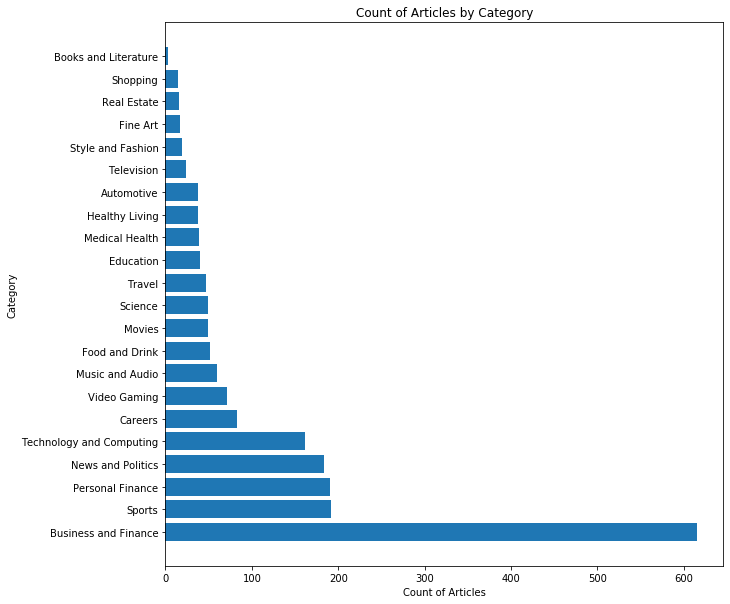

In [5]:
category_sub = train['category'].value_counts().rename_axis('Category').reset_index(name='Count').sort_values('Count', ascending = False)
plt.figure(figsize=(10,10))
plt.barh('Category', 'Count',data=category_sub)
plt.xlabel("Count of Articles")
plt.ylabel("Category")
plt.title("Count of Articles by Category")

<h3>Defining all functions required for data preprocessing and model build<h3>

In [7]:
#this function is called to remove punctuatios, numbers, stop words, proper nouns and lemmatize the articles
def preprocess(df_ip):
    remove_punctuation = "".join([i for i in df_ip if i not in string.punctuation])
    remove_number =''.join(i for i in remove_punctuation if not i.isdigit())
    remove_stopWords= [i for i in remove_number.lower().split() if i not in stopwords]
    lemmatize_text = [wordnet_lemmatizer.lemmatize(word) for word in remove_stopWords]
    pos_tag_text = nltk.tag.pos_tag(lemmatize_text)
    edited_text = [word for word,tag in pos_tag_text if (tag != 'NNP' and tag != 'NNPS')]
    edited_text_as_str = ' '.join(str(e) for e in edited_text)
    return edited_text_as_str

#this function is used to get the word count
def word_count(df_ip):
    article_length = len(df_ip)
    return article_length

#this function will be used to kick-off multiple models and output a classification report with precision, recall and f1 metrics
def train_test_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    metrics_report = classification_report(y_test, predictions)
    precision, recall, fscore, train_support = score(y_test, predictions, average='weighted')
    print(classification_report(y_test, predictions))
    return (precision, recall, fscore)

#this function will be used to configure parameters for different models to be run
def run_models(X_train, X_test, y_train, y_test, class_weights):
    #Fitting a Random Forest model, accounting for class imbalance with class_weight = "balanced"
    model  = RandomForestClassifier(random_state=1, class_weight = 'balanced')

    n_estimators = [50,100,150,200]
    max_depth = [5, 10,15,20,25,30]
    min_samples_leaf = [5,10,20,30,40,50] 

    hyper_params = dict(n_estimators = n_estimators, max_depth = max_depth,  
                 min_samples_leaf = min_samples_leaf)

    grid = GridSearchCV(model, hyper_params, cv = 3, verbose = 1, 
                          n_jobs = -1)
    best_param = grid.fit(X_train, y_train)
    model = best_param.best_estimator_

    rf_metrics = []
    rf_metrics = train_test_model(model, X_train, X_test, y_train, y_test)
    
    #Fitting a logistic regression, accounting for class imbalance with class_weight = "balanced"
    model = LogisticRegression(class_weight = 'balanced')
    param_grid = {'C': [0.1,0.001,1],
        # regularization penalty
        'penalty' : ['l2'] }
    clf = GridSearchCV(model, param_grid, cv = 3, verbose = 1)

    bestF = clf.fit(X_train, y_train)
    bestF.best_estimator_
    model = bestF.best_estimator_
    lr_metrics = []
    lr_metrics = train_test_model(model, X_train, X_test, y_train, y_test)
    
    #fitting a catboost
    #setting weights proportional to distribution to account for calss imbalance
    cb_model = CatBoostClassifier(max_depth=10, loss_function='MultiClass', class_weights = class_weights, iterations = 50, random_state=1, silent=True)
    cb_metrics = []
    cb_metrics = train_test_model(cb_model, X_train, X_test, y_train, y_test)
    
    return lr_metrics, rf_metrics, cb_metrics

#this function is used for Comparing overall model performances using metrics -> precision, recall and f1
def comp_model_perf(lr_metrics, rf_metrics, cb_metrics):

    xx = np.array([1,2,3])
    width = 0.15
    ax = plt.subplot(111)
    ax.bar( xx - width, height=np.array(lr_metrics), width=width, align='center', label='Logistic', tick_label=['Precision', 'Recall', 'f1'])
    ax.bar(xx ,height=np.array(rf_metrics), width=width, align='center', label='Random_Forest')
    ax.bar(xx + width, height=np.array(cb_metrics), width=width, align='center', label='Catboost')

    plt.xlabel('Classification Metrics')
    plt.ylabel('Scores')
    plt.legend(loc='lower right')
    plt.show()

#this function is used to find similarity between document categories
def most_similar(data_ip, doc_id,similarity_matrix,matrix):
    categories = []
    sim_score = []
    if matrix=='Cosine Similarity':
        similar_ix=np.argsort(similarity_matrix[doc_id])[::-1]
    for ix in similar_ix:
        if (ix==doc_id) | (data_ip.iloc[ix]["category"] == data_ip.iloc[doc_id]["category"]):
            continue
        category = data_ip.iloc[ix]["category"]
        score = similarity_matrix[doc_id][ix]
        break
    return category, score

<h3> Preprocessing train an test documents <h3>

In [8]:
train['cleaned'] = train['text'].apply(lambda x: preprocess(x))
train['article_length'] = train['text'].apply(lambda x: word_count(x))
test = pd.read_csv("eval_data.csv")
test['cleaned'] = test['text'].apply(lambda x: preprocess(x))

In [9]:
train.head()

,natid,title,pub_date,uri,category,text,cleaned,article_length
0,blogandpostid/blog/post/3949-40365,You're Already On A Cloud -- What Could Poss...,2020-05-07,http://www.forbes.com/sites/forbestechcouncil/...,Technology and Computing,Photo: Some people are born entrepreneurs. No...,people born entrepreneur nothing make happier ...,5049
1,blogandpostid/blog/post/6196-5f0a292c92ce9a000...,Painful Loss Of Employment Income Impacts Over...,2020-07-11,http://www.forbes.com/sites/mayrarodriguezvall...,Personal Finance,Job losses in New York are having a very adve...,job loss new york adverse effect new yorkers i...,3747
2,blogandpostid/blog/post/5660-5e86d6eaf40e13000...,Visa Is About To Give Bitcoin Adoption A Boost,2020-04-13,http://www.forbes.com/sites/billybambrough/202...,Personal Finance,"Bitcoin adoption, something that has somewhat...",bitcoin adoption something somewhat stagnated ...,2954
3,blogandpostid/blog/post/5256-5ed172ca9879a0000...,The American Workplace Is Reopening. Are Emplo...,2020-05-29,http://www.forbes.com/sites/insights-zoom/2020...,Business and Finance,"By Richard Sine Ready or not, American workpl...",richard sine ready american workplace revving ...,5686
4,blogandpostid/blog/post/1408-5ee78f581b05b0000...,Defunding Police Will Hurt America’s Small Bus...,2020-06-15,http://www.forbes.com/sites/jimblasingame/2020...,News and Politics,No other single group does more to benefit Am...,single group benefit america main street busin...,5064


<h3>Exploring eval dataset shows it is missing some categories, will randomly sample them from train dataset to use<h3>

In [10]:
test.category.value_counts()

Business and Finance        28
News and Politics           10
Technology and Computing    10
Sports                       9
Personal Finance             8
Music and Audio              5
Science                      5
Travel                       5
Video Gaming                 4
Careers                      4
Real Estate                  3
Style and Fashion            2
Books and Literature         1
Shopping                     1
Television                   1
Education                    1
Healthy Living               1
Automotive                   1
Food and Drink               1
Name: category, dtype: int64

In [12]:
train_target = set(train['category'].unique())
test_target = set(test['category'].unique())
missing_test_cat = train_target - test_target
missing_test_cat
list_of_strings = [str(s) for s in missing_test_cat]
joined_string = ",".join(list_of_strings)
df_sub = train.groupby('category').apply(lambda s: s.sample(frac = 0.05))
df_sub_app = df_sub[['natid','title','pub_date','uri','category','text','cleaned','article_length']].query('category == "Movies" | category == "Medical Health" | category == "Fine Art"')
df_sub_app.reset_index(drop=True, inplace=True)

<h3>Final train and test data to use<h3>

In [14]:
test_all_cats = test.append(df_sub_app, ignore_index=True)
#drop indexes that were used in test
train_upd = train.drop([107, 1119, 1366, 76, 1145])

In [15]:
train_upd.reset_index(drop=True, inplace=True)

<h3>encoding the target variable<h3>

In [17]:
label_encoder = preprocessing.LabelEncoder() 
train_upd['category_encoded']= label_encoder.fit_transform(train_upd['category'])
test_all_cats['category_encoded']= label_encoder.fit_transform(test_all_cats['category'])

In [18]:
X_train = train_upd['cleaned']
y_train = train_upd['category_encoded']
X_test = test_all_cats['cleaned']
y_test = test_all_cats['category_encoded']

<h3>to create features, will use the document to create feature vectors<h3>
<h4>using Term frequency to create the vectors<h4>

In [20]:
#start creating features from the cleaned text
#will use term frequency to begin
coun_vect = CountVectorizer(max_df=0.75,
                            min_df=2,
                            max_features=1000)
train_features = coun_vect.fit_transform(X_train).toarray()
print(train_features.shape)

test_features = coun_vect.transform(X_test).toarray()
print(test_features.shape)

(1995, 1000)
(105, 1000)


<h3>Logistic does the best in terms of being able to predict individual categories and also has a higher average metrics compared to random forest and catboost<h3>

In [25]:
#calling model build and comparing precision, recall and f1 metrics across models - tf representation
lr_metrics = [] 
rf_metrics = [] 
cb_metrics = []
class_weights = []
#set class weights proportional to distribution of categories in the full dataset
class_weights = [0.69,0.90,0.90,0.91,0.92,0.96,0.96,0.97,0.97,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.99,0.99,0.99,0.99,0.99,1.00]
lr_metrics, rf_metrics, cb_metrics = run_models(train_features, test_features, y_train, y_test, class_weights)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  1.1min finished


              precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       0.00      0.00      0.00         1
           2       0.80      0.43      0.56        28
           3       1.00      0.75      0.86         4
           4       0.50      1.00      0.67         1
           5       0.50      1.00      0.67         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       0.33      1.00      0.50         2
           9       0.67      1.00      0.80         2
          10       1.00      1.00      1.00         5
          11       0.69      0.90      0.78        10
          12       0.58      0.88      0.70         8
          13       1.00      0.67      0.80         3
          14       0.00      0.00      0.00         5
          15       0.50      1.00      0.67         1
          16       1.00      0.89      0.94         9
          17       1.00    

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.7s finished


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       0.77      0.86      0.81        28
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       0.50      1.00      0.67         1
           7       0.00      0.00      0.00         1
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         5
          11       0.69      0.90      0.78        10
          12       0.75      0.75      0.75         8
          13       1.00      0.67      0.80         3
          14       0.67      0.40      0.50         5
          15       1.00      1.00      1.00         1
          16       1.00      0.78      0.88         9
          17       0.67    

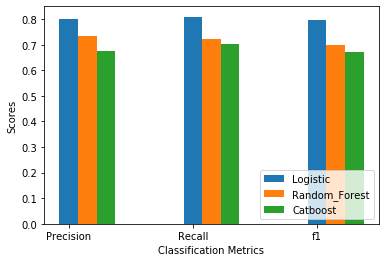

In [26]:
comp_model_perf(lr_metrics, rf_metrics, cb_metrics)

<h3>using tfidf for feature vectors<h3>

In [28]:

tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=(1,1),
                        stop_words=None,
                        lowercase=False,
                        max_df=0.75,
                        min_df=2,
                        max_features=1000,
                        norm='l2',
                        sublinear_tf=True)
                        
train_features = tfidf.fit_transform(X_train).toarray()
print(train_features.shape)

test_features = tfidf.transform(X_test).toarray()
print(test_features.shape)

(1995, 1000)
(105, 1000)


In [30]:
#calling model build and comparing precision, recall and f1 metrics across models - tfidf representation
lr_metrics, rf_metrics, cb_metrics = run_models(train_features, test_features, y_train, y_test, class_weights)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  1.6min finished


              precision    recall  f1-score   support

           0       0.25      1.00      0.40         1
           1       0.00      0.00      0.00         1
           2       0.68      0.54      0.60        28
           3       0.60      0.75      0.67         4
           4       0.33      1.00      0.50         1
           5       1.00      1.00      1.00         1
           6       0.50      1.00      0.67         1
           7       1.00      1.00      1.00         1
           8       0.67      1.00      0.80         2
           9       0.50      1.00      0.67         2
          10       0.83      1.00      0.91         5
          11       0.78      0.70      0.74        10
          12       0.60      0.75      0.67         8
          13       0.67      0.67      0.67         3
          14       0.00      0.00      0.00         5
          15       1.00      1.00      1.00         1
          16       0.78      0.78      0.78         9
          17       1.00    

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.1s finished


              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1
           2       0.88      0.50      0.64        28
           3       0.44      1.00      0.62         4
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       0.33      1.00      0.50         1
           7       0.00      0.00      0.00         1
           8       0.50      1.00      0.67         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         5
          11       0.82      0.90      0.86        10
          12       0.80      1.00      0.89         8
          13       0.67      0.67      0.67         3
          14       0.60      0.60      0.60         5
          15       0.50      1.00      0.67         1
          16       1.00      0.89      0.94         9
          17       0.67    

<h3>slighly higher precision than recall in this scenario<h3>

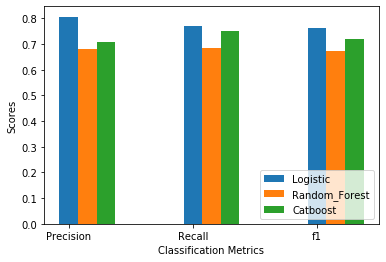

In [31]:
comp_model_perf(lr_metrics, rf_metrics, cb_metrics)

<h3>there are still 2 categories -> 7 and 19 where the logistic model still fails to classify<h3>

In [37]:
#category 7 = "television", 19 = "healthy living"
train_upd.query('category_encoded == 19')

,natid,title,pub_date,uri,category,text,cleaned,article_length,category_encoded
275,blogandpostid/blog/post/5669-5e83f1f18aedb8000...,Discovery Channel’s Nancy Daniels On Programmi...,2020-04-01,http://www.forbes.com/sites/tonifitzgerald/202...,Television,"When you find something that works, you stick...",find something work stick philosophy worked we...,5357,19
282,blogandpostid/blog/post/6688-5ee3ad42302a5b000...,Review: ‘The Bold Type’ Season 4 Summer Premiere,2020-06-12,http://www.forbes.com/sites/lindamaleh/2020/06...,Television,* This article contains spoilers for The Bold...,article contains spoiler bold type season epis...,4241,19
300,blogandpostid/blog/post/5631-5ea5e2f535e545000...,"Lil Dicky May Be Super Famous Now, But He’s No...",2020-04-29,http://www.forbes.com/sites/derekscancarelli/2...,Television,It's been a busy month for Dave Burd. For the...,busy month dave burd past week rapper known li...,12404,19
367,blogandpostid/blog/post/4679-5e8a8dfd4227c6000...,"‘Westworld’ Recap, Season 3, Episode 4: Dolore...",2020-04-05,http://www.forbes.com/sites/adriennegibbs/2020...,Television,The following is a recap that contains spoile...,following recap contains spoiler westworld dea...,11044,19
459,blogandpostid/blog/post/6857-5ebe9b4dc2bec4000...,K-Drama Comedy ‘Oh My Baby’ Presents Jang Nara...,2020-05-15,http://www.forbes.com/sites/joanmacdonald/2020...,Television,"In the quickly-paced k-comedy Oh My Baby, Jan...",quicklypaced kcomedy oh baby jang nara play ja...,2849,19
565,blogandpostid/blog/post/3101-5e1ef34dedd3df000...,Netflix: Big Data And Playing A Long Game Is P...,2020-01-15,http://www.forbes.com/sites/enriquedans/2020/0...,Television,I have written on several occasions about Net...,written several occasion netflixs use data ana...,4414,19
595,blogandpostid/blog/post/6688-5f11c41c262cd4000...,Review: ‘The Bold Type’ Season 4 Finale Explor...,2020-07-17,http://www.forbes.com/sites/lindamaleh/2020/07...,Television,It feels like just yesterday that Sutton (Meg...,feel like yesterday sutton meghann fahy richar...,4626,19
781,blogandpostid/blog/post/1174-5e1346fb97eb3e000...,A Must-Hear ‘The Witcher’ Voice Comparison: Ne...,2020-01-06,http://www.forbes.com/sites/paultassi/2020/01/...,Television,"Unless you're a critic from a major outlet, y...",unless youre critic major outlet probably most...,2731,19
814,blogandpostid/blog/post/6856-5e5ac2cbb74ffb000...,Hilary Duff Asks Disney Plus To Move ‘Lizzie M...,2020-02-29,http://www.forbes.com/sites/monicamercuri/2020...,Television,Actress Hilary Duff says she can bring her be...,actress hilary duff say bring beloved characte...,2796,19
833,blogandpostid/blog/post/5987-5ee65eaf1b05b0000...,Perfect Hudson Valley Excursion: Following The...,2020-06-30,http://www.forbes.com/sites/margiegoldsmith/20...,Television,"Six months ago, American vacationers ventured...",six month ago american vacationer ventured eve...,5514,19


<h4>there were some categories that had less than 30 instances, revisiting those to see if some of them can be combined?<h4>
<h4>1 way to do it would be combining categroies that sound intuitively similar, for e.g. Television and Movies, but is that always the case?<h4>
<h4>one way to confirm would be using similarity metrics<h4>

<h4>===============================<h4>
<h4>Category                  Count<h4>
<h4>===============================<h4>
<h4>Television                   24<h4>
<h4>Style and Fashion            19<h4>
<h4>Fine Art                     17<h4>
<h4>Real Estate                  16<h4>
<h4>Shopping                     14<h4>
<h4>Books and Literature          3<h4> 

In [41]:
#computing similarity using cosine similarity score and tfidf feature vectors
pairwise_similarities=np.dot(tfidf.fit_transform(X_train),tfidf.fit_transform(X_train).T).toarray()

In [42]:
#picking some examples from TV
train_upd.query('category == "Television"')

,natid,title,pub_date,uri,category,text,cleaned,article_length,category_encoded
275,blogandpostid/blog/post/5669-5e83f1f18aedb8000...,Discovery Channel’s Nancy Daniels On Programmi...,2020-04-01,http://www.forbes.com/sites/tonifitzgerald/202...,Television,"When you find something that works, you stick...",find something work stick philosophy worked we...,5357,19
282,blogandpostid/blog/post/6688-5ee3ad42302a5b000...,Review: ‘The Bold Type’ Season 4 Summer Premiere,2020-06-12,http://www.forbes.com/sites/lindamaleh/2020/06...,Television,* This article contains spoilers for The Bold...,article contains spoiler bold type season epis...,4241,19
300,blogandpostid/blog/post/5631-5ea5e2f535e545000...,"Lil Dicky May Be Super Famous Now, But He’s No...",2020-04-29,http://www.forbes.com/sites/derekscancarelli/2...,Television,It's been a busy month for Dave Burd. For the...,busy month dave burd past week rapper known li...,12404,19
367,blogandpostid/blog/post/4679-5e8a8dfd4227c6000...,"‘Westworld’ Recap, Season 3, Episode 4: Dolore...",2020-04-05,http://www.forbes.com/sites/adriennegibbs/2020...,Television,The following is a recap that contains spoile...,following recap contains spoiler westworld dea...,11044,19
459,blogandpostid/blog/post/6857-5ebe9b4dc2bec4000...,K-Drama Comedy ‘Oh My Baby’ Presents Jang Nara...,2020-05-15,http://www.forbes.com/sites/joanmacdonald/2020...,Television,"In the quickly-paced k-comedy Oh My Baby, Jan...",quicklypaced kcomedy oh baby jang nara play ja...,2849,19
565,blogandpostid/blog/post/3101-5e1ef34dedd3df000...,Netflix: Big Data And Playing A Long Game Is P...,2020-01-15,http://www.forbes.com/sites/enriquedans/2020/0...,Television,I have written on several occasions about Net...,written several occasion netflixs use data ana...,4414,19
595,blogandpostid/blog/post/6688-5f11c41c262cd4000...,Review: ‘The Bold Type’ Season 4 Finale Explor...,2020-07-17,http://www.forbes.com/sites/lindamaleh/2020/07...,Television,It feels like just yesterday that Sutton (Meg...,feel like yesterday sutton meghann fahy richar...,4626,19
781,blogandpostid/blog/post/1174-5e1346fb97eb3e000...,A Must-Hear ‘The Witcher’ Voice Comparison: Ne...,2020-01-06,http://www.forbes.com/sites/paultassi/2020/01/...,Television,"Unless you're a critic from a major outlet, y...",unless youre critic major outlet probably most...,2731,19
814,blogandpostid/blog/post/6856-5e5ac2cbb74ffb000...,Hilary Duff Asks Disney Plus To Move ‘Lizzie M...,2020-02-29,http://www.forbes.com/sites/monicamercuri/2020...,Television,Actress Hilary Duff says she can bring her be...,actress hilary duff say bring beloved characte...,2796,19
833,blogandpostid/blog/post/5987-5ee65eaf1b05b0000...,Perfect Hudson Valley Excursion: Following The...,2020-06-30,http://www.forbes.com/sites/margiegoldsmith/20...,Television,"Six months ago, American vacationers ventured...",six month ago american vacationer ventured eve...,5514,19


In [44]:
#looks like this instance was similar to "Music & Audio"
category, score = most_similar(train_upd,300,pairwise_similarities,'Cosine Similarity')
print(category)
print(score)

Music and Audio
0.5365583832787044


In [45]:
#this seems more similar to "Movies", 
cat, score = most_similar(train_upd,595,pairwise_similarities,'Cosine Similarity')
print(cat)
print(score)

Movies
0.3410286718993876


In [46]:
#this seems more similar to "Travel", 
#it would probably make sense to group small instances with categories they are similar on a case basis
cat, score = most_similar(train_upd,833,pairwise_similarities,'Cosine Similarity')
print(cat)
print(score)

Travel
0.34724223335362664


<h4>down to 16 from 22<h4>

In [47]:

for index, row in train_upd.query('category == "Television"').iterrows():
    category, score = most_similar(train_upd,index,pairwise_similarities,'Cosine Similarity')
    train_upd.at[index, 'category'] = category

for index, row in train_upd.query('category == "Style and Fashion"').iterrows():
    category, score = most_similar(train_upd,index,pairwise_similarities,'Cosine Similarity')
    train_upd.at[index, 'category'] = category

for index, row in train_upd.query('category == "Fine Art"').iterrows():
    category, score = most_similar(train_upd,index,pairwise_similarities,'Cosine Similarity')
    train_upd.at[index, 'category'] = category

for index, row in train_upd.query('category == "Real Estate"').iterrows():
    category, score = most_similar(train_upd,index,pairwise_similarities,'Cosine Similarity')
    train_upd.at[index, 'category'] = category
    
for index, row in train_upd.query('category == "Shopping"').iterrows():
    category, score = most_similar(train_upd,index,pairwise_similarities,'Cosine Similarity')
    train_upd.at[index, 'category'] = category

for index, row in train_upd.query('category == "Books and Literature"').iterrows():
    category, score = most_similar(train_upd,index,pairwise_similarities,'Cosine Similarity')
    train_upd.at[index, 'category'] = category
    
train_upd['category'].value_counts()

Business and Finance        658
Personal Finance            196
Sports                      193
News and Politics           187
Technology and Computing    163
Careers                      83
Music and Audio              78
Video Gaming                 74
Food and Drink               56
Travel                       54
Science                      50
Movies                       49
Education                    41
Automotive                   38
Healthy Living               38
Medical Health               37
Name: category, dtype: int64

<h4>applying the same for eval dataset<h4>

In [49]:

pairwise_similarities_test=np.dot(tfidf.fit_transform(X_test),tfidf.fit_transform(X_test).T).toarray()
for index, row in test_all_cats.query('category == "Television"').iterrows():
    category, score = most_similar(test_all_cats,index,pairwise_similarities_test,'Cosine Similarity')
            #print(category, score)
    test_all_cats.at[index, 'category'] = category

for index, row in test_all_cats.query('category == "Style and Fashion"').iterrows():
    category, score = most_similar(test_all_cats,index,pairwise_similarities_test,'Cosine Similarity')
    print(category, score)
    test_all_cats.at[index, 'category'] = category

for index, row in test_all_cats.query('category == "Real Estate"').iterrows():
    category, score = most_similar(test_all_cats,index,pairwise_similarities_test,'Cosine Similarity')
    print(category, score)
    test_all_cats.at[index, 'category'] = category
    
for index, row in test_all_cats.query('category == "Fine Art"').iterrows():
    category, score = most_similar(test_all_cats,index,pairwise_similarities_test,'Cosine Similarity')
    #print(category, score)
    test_all_cats.at[index, 'category'] = category
    

for index, row in test_all_cats.query('category == "Shopping"').iterrows():
    category, score = most_similar(test_all_cats,index,pairwise_similarities_test,'Cosine Similarity')
    #print(category, score)
    test_all_cats.at[index, 'category'] = category

for index, row in test_all_cats.query('category == "Books and Literature"').iterrows():
    category, score = most_similar(test_all_cats,index,pairwise_similarities_test,'Cosine Similarity')
    #print(category, score)
    test_all_cats.at[index, 'category'] = category

#down to 16 categories from 22
test_all_cats['category'].value_counts()

Shopping 0.1948316041558411
Shopping 0.2437854566776243
Travel 0.2583083357344027
Careers 0.25861498627930274
Travel 0.29316397656327015


Business and Finance        33
Technology and Computing    11
News and Politics           10
Sports                       9
Personal Finance             8
Travel                       7
Music and Audio              5
Science                      5
Careers                      5
Video Gaming                 4
Medical Health               2
Movies                       2
Automotive                   1
Education                    1
Healthy Living               1
Food and Drink               1
Name: category, dtype: int64

In [50]:
train_upd['category_encoded']= label_encoder.fit_transform(train_upd['category'])
test_all_cats['category_encoded']= label_encoder.fit_transform(test_all_cats['category'])
X_train = train_upd['cleaned']
y_train = train_upd['category_encoded']
X_test = test_all_cats['cleaned']
y_test = test_all_cats['category_encoded']

#updating class weights
class_weights = [0.67,0.90,0.90,0.91,0.92,0.96,0.96,0.96,0.97,0.97,0.97,0.98,0.98,0.98,0.98,0.98]

In [51]:
#start creating features from the cleaned text
#will use term frequency
coun_vect = CountVectorizer(max_df=0.75,
                            min_df=2,
                            max_features=1000)
train_features = coun_vect.fit_transform(X_train).toarray()
print(train_features.shape)

test_features = coun_vect.transform(X_test).toarray()
print(test_features.shape)

(1995, 1000)
(105, 1000)


In [55]:
#calling model build and comparing precision, recall and f1 metrics across models - tf representation
lr_metrics = [] 
rf_metrics = [] 
cb_metrics = []
lr_metrics, rf_metrics, cb_metrics = run_models(train_features, test_features, y_train, y_test, class_weights)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  1.1min finished


              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.82      0.55      0.65        33
           2       0.75      0.60      0.67         5
           3       1.00      1.00      1.00         1
           4       0.33      1.00      0.50         1
           5       1.00      1.00      1.00         1
           6       0.50      1.00      0.67         2
           7       0.67      1.00      0.80         2
           8       1.00      1.00      1.00         5
           9       0.73      0.80      0.76        10
          10       0.46      0.75      0.57         8
          11       0.50      0.20      0.29         5
          12       0.73      0.89      0.80         9
          13       0.62      0.73      0.67        11
          14       1.00      0.71      0.83         7
          15       0.80      1.00      0.89         4

    accuracy                           0.70       105
   macro avg       0.71   

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.2s finished


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.76      0.76      0.76        33
           2       1.00      0.80      0.89         5
           3       0.50      1.00      0.67         1
           4       0.25      1.00      0.40         1
           5       0.00      0.00      0.00         1
           6       0.67      1.00      0.80         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         5
           9       0.69      0.90      0.78        10
          10       0.60      0.75      0.67         8
          11       0.67      0.40      0.50         5
          12       1.00      0.78      0.88         9
          13       0.75      0.55      0.63        11
          14       1.00      0.71      0.83         7
          15       0.80      1.00      0.89         4

    accuracy                           0.76       105
   macro avg       0.73   

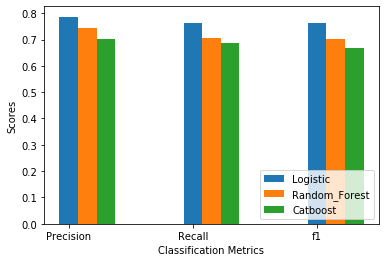

In [56]:
comp_model_perf(lr_metrics, rf_metrics, cb_metrics)

In [57]:
train_upd.query('category_encoded == 5')

,natid,title,pub_date,uri,category,text,cleaned,article_length,category_encoded
36,blogandpostid/blog/post/4424-5e21bbdf142d30000...,"Top 10 Tips For Running A Global NGO, From The...",2020-01-17,http://www.forbes.com/sites/meimeifox/2020/01/...,Healthy Living,"On January 30, 2020, The HOPE Foundation will...",january hope foundation celebrate th anniversa...,4142,5
88,blogandpostid/blog/post/7310-5e87815fb47ecd000...,3 Tips From Psychology On How To Stay Calm Dur...,2020-04-06,http://www.forbes.com/sites/traversmark/2020/0...,Healthy Living,"In a recent press conference, President Donal...",recent press conference president trump warned...,3871,5
143,blogandpostid/blog/post/4251-5e98814ec8ee69000...,Doctors From The World-Renowned Clinique La Pr...,2020-04-16,http://www.forbes.com/sites/meggentaylor/2020/...,Healthy Living,If there's one take away from the coronavirus...,there one take away coronavirus pandemic boost...,12827,5
254,blogandpostid/blog/post/4036-5e7137eaab2581000...,How To Preserve Your Mental Strength When Ever...,2020-03-17,http://www.forbes.com/sites/pauladavislaack/20...,Healthy Living,I don't think this is quite how most people e...,dont think quite people expected new decade un...,5742,5
266,blogandpostid/blog/post/3036-5eeecfe93ec5af000...,Strong Father-Daughter Relationships Lead To H...,2020-06-21,http://www.forbes.com/sites/nicolefisher/2020/...,Healthy Living,Father's Day is the specified time each year ...,father day specified time year feel obligated ...,5518,5
354,blogandpostid/blog/post/4983-5e711704bdb70e000...,10 Things To Do When You’re Sick Of Binge-Watc...,2020-03-18,http://www.forbes.com/sites/forbes-personal-sh...,Healthy Living,"For introverts, staying in for an extended pe...",introvert staying extended period time easy ev...,5515,5
355,blogandpostid/blog/post/4999-5e10d420060ee9000...,Are You Still Making Resolutions? Try Three Wo...,2020-01-04,http://www.forbes.com/sites/alisacohn/2020/01/...,Healthy Living,Are you someone who makes New Year's resoluti...,someone make new year resolution work great si...,2912,5
503,blogandpostid/blog/post/4025-32145,Five Daily Habits To Unleash Your Creativity I...,2020-01-16,http://www.forbes.com/sites/forbescoachescounc...,Healthy Living,PHOTO Everyone has creative potential. The ke...,everyone creative potential key unlocking dail...,5008,5
621,blogandpostid/blog/post/4911-5efb4dabf2b693000...,How Nike Master Trainer Kirsty Godso Can Get Y...,2020-06-30,http://www.forbes.com/sites/isisbriones/2020/0...,Healthy Living,Getting in shape especially during the corona...,getting shape especially coronavirus pandemic ...,5959,5
648,blogandpostid/blog/post/6515-5efa97a621ae76000...,3 Mind Traps That Sabotage Leadership In Turbu...,2020-06-29,http://www.forbes.com/sites/curtsteinhorst/202...,Healthy Living,Raise your hand if you've heard a thousand ti...,raise hand youve heard thousand time today wor...,9589,5


<h3> with combining categories with low occurence, we improved on the classification for category Television while Healthy Living is still an issue, the overall performance of the model is still at an F1 score of 0.78 <h3>

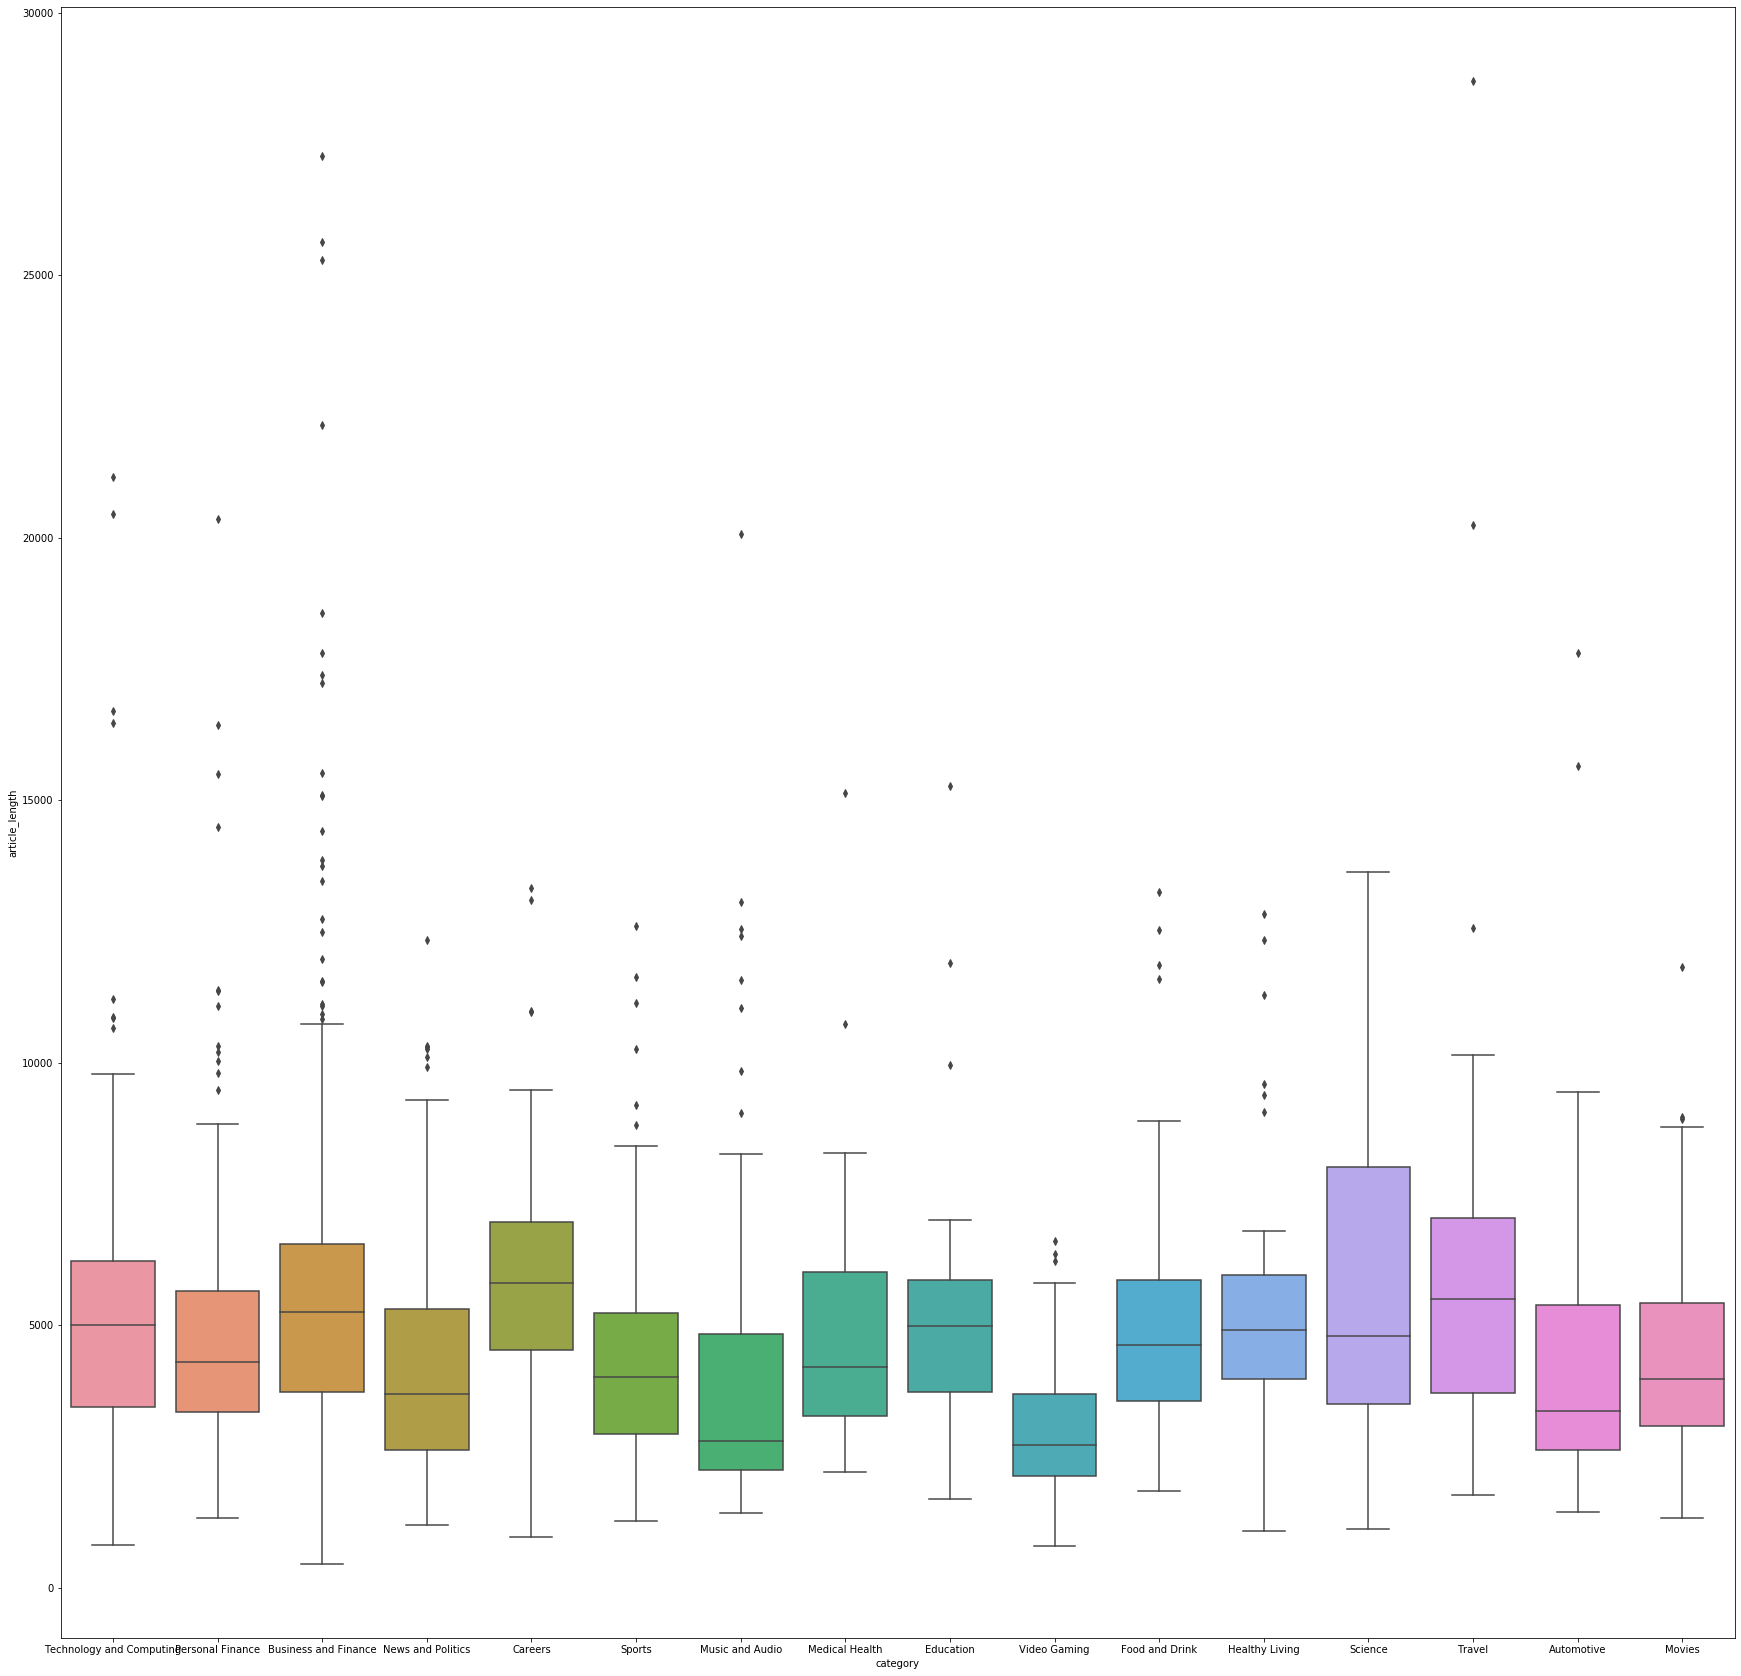

In [60]:
plt.figure(figsize = (30,30))
sns.boxplot(x = train_upd['category'],
            y = train_upd['article_length'])

<h4>The advantage to the approach above is, it is a simpler model which is intuitive with less hardware overhead and we are able to achieve aa average f1 score of 0.78<h4>
<h4> there is however future enhancement considerations to this: <h4>
<h4>1. healthy living can be combined with similar category, or it would make sense to investigate the vectors/outliers to identify issue related to classification<h4>
<h4>2. the length distribution above suggests some outliers, it would be good to treat them before creating feature vectors<h4>
<h4>3. we could use other balancing strategies such as oversampling, undersampling or smote<h4>
<h4>4. we would use other context aware models to generate feature vectors/word embeddings such as doc2vec/glove/bert to improve classification<h4>
<h4>5. another startegy could be to combine an unsupervised learning technique such as LDA to generate topics and then use them in classifying categories<h4>